In [1]:
example_segment = '../Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/'

In [2]:
import os
import sys
import numpy as np
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.append('..')
os.listdir(example_segment) # all the files present for every minute of driving

['processed_log', 'global_pose', 'raw_log.bz2', 'video.hevc', 'preview.png']

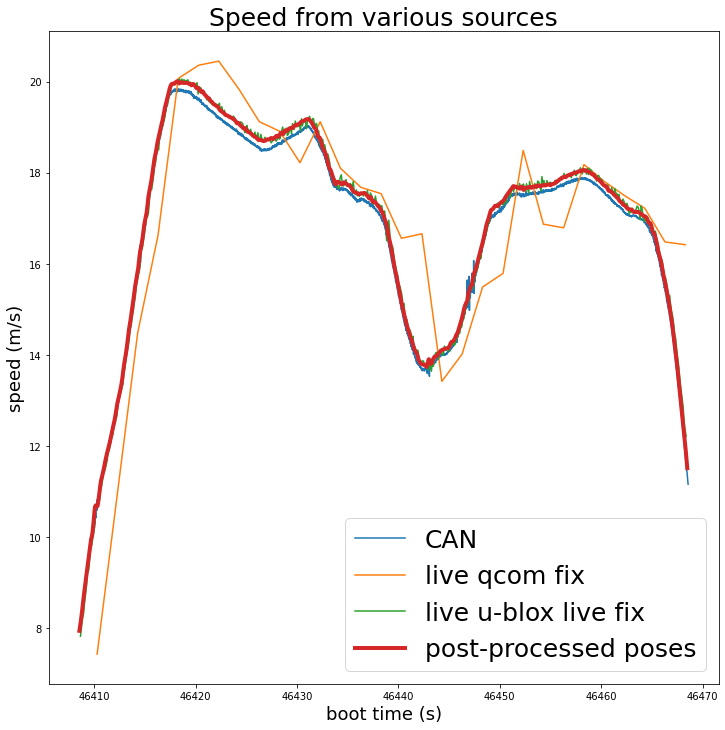

In [4]:
# We can plot the speed from a variety of sources
figsize(12,12);

# from can data
plot(np.load(example_segment + 'processed_log/CAN/speed/t'),
     np.load(example_segment + 'processed_log/CAN/speed/value'),
     label='CAN');

# from qcom gnss data
plot(np.load(example_segment + 'processed_log/GNSS/live_gnss_qcom/t'),
     np.load(example_segment + 'processed_log/GNSS/live_gnss_qcom/value')[:,2],
     label='live qcom fix');

# from u-blox gnss data
plot(np.load(example_segment + 'processed_log/GNSS/live_gnss_ublox/t'),
     np.load(example_segment + 'processed_log/GNSS/live_gnss_ublox/value')[:,2],
     label='live u-blox live fix');

# from post-processed data
plot(np.load(example_segment + 'global_pose/frame_times'),
     np.linalg.norm(np.load(example_segment + 'global_pose/frame_velocities'),axis=1), linewidth=4,
     label='post-processed poses');

title('Speed from various sources', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('speed (m/s)', fontsize=18);


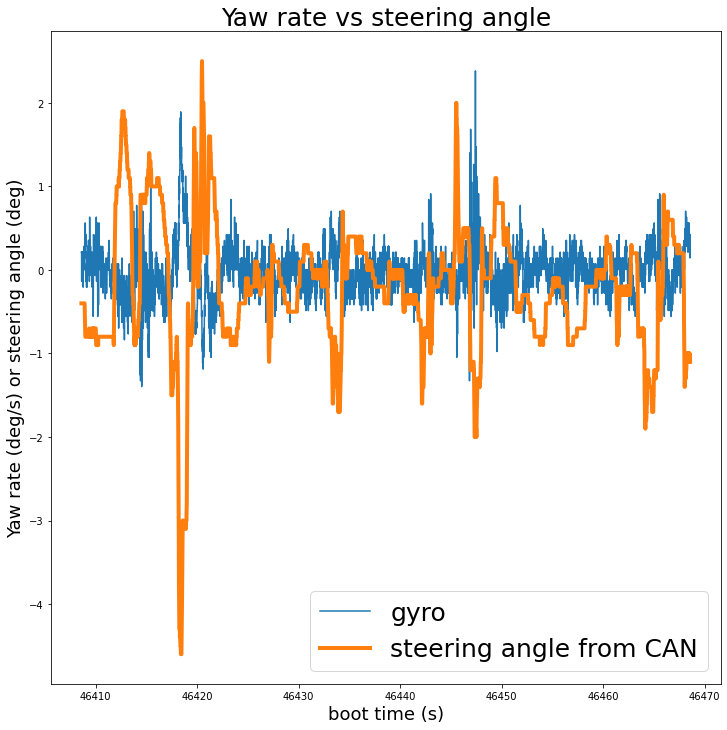

In [5]:
# We can plot the yaw rate and compare it to the steering angle
# This segment doesn't have much turning, if it did we would see
# very clear negative correlation, now we only see it at about
# 12s into the segment.
figsize(12,12);

# yaw rate from gyro
plot(np.load(example_segment + 'processed_log/IMU/gyro/t'),
     (180/pi)*np.load(example_segment + 'processed_log/IMU/gyro/value')[:,2],
     label='gyro');

# from can data we
plot(np.load(example_segment + 'processed_log/CAN/steering_angle/t'),
     np.load(example_segment + 'processed_log/CAN/steering_angle/value'), linewidth=4,
     label='steering angle from CAN')


title('Yaw rate vs steering angle', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('Yaw rate (deg/s) or steering angle (deg)', fontsize=18);

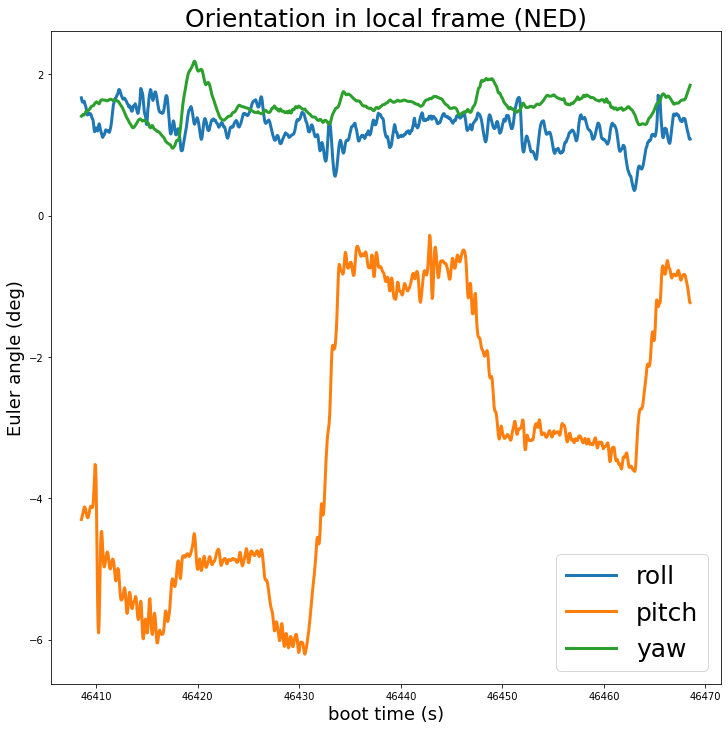

In [6]:
import utils.orientation as orient
import utils.coordinates as coord

# we can plot the orientation of the camera in 
# euler angles respective to the local ground plane,
# i.e. the North East Down reference frame. This is more
# intuitive than the quaternion.

frame_times = np.load(example_segment + 'global_pose/frame_times')
frame_positions = np.load(example_segment + 'global_pose/frame_positions')
frame_orientations = np.load(example_segment + 'global_pose/frame_orientations')
euler_angles_ned_deg = (180/pi)*orient.ned_euler_from_ecef(frame_positions[0], orient.euler_from_quat(frame_orientations))


plot(frame_times, euler_angles_ned_deg[:,0], label='roll', linewidth=3);
plot(frame_times, euler_angles_ned_deg[:,1], label='pitch', linewidth=3);
plot(frame_times, euler_angles_ned_deg[:,2], label='yaw', linewidth=3);
title('Orientation in local frame (NED)', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('Euler angle (deg)', fontsize=18);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


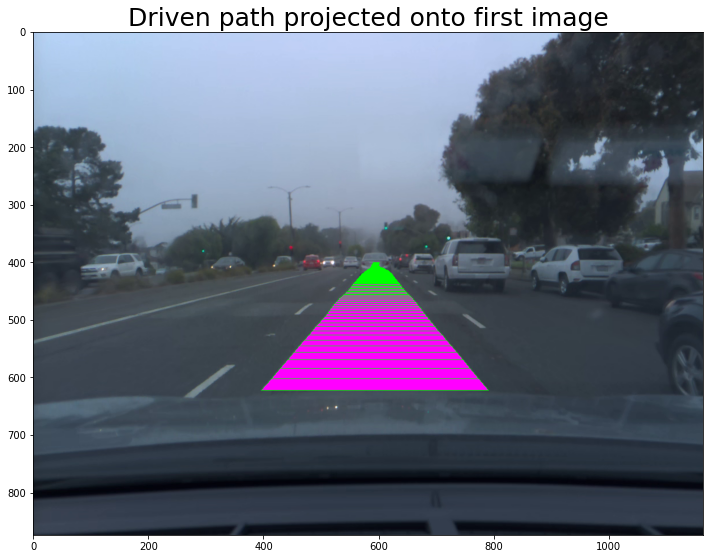

In [7]:
# We can project the path driven onto the first image

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

from utils.camera import img_from_device, denormalize, view_frame_from_device_frame

def draw_path(device_path, img, width=1, height=1.2, fill_color=(128,0,255), line_color=(0,255,0)):
  device_path_l = device_path + np.array([0, 0, height])                                                                    
  device_path_r = device_path + np.array([0, 0, height])                                                                    
  device_path_l[:,1] -= width                                                                                               
  device_path_r[:,1] += width

  img_points_norm_l = img_from_device(device_path_l)
  img_points_norm_r = img_from_device(device_path_r)
  img_pts_l = denormalize(img_points_norm_l)
  img_pts_r = denormalize(img_points_norm_r)

  # filter out things rejected along the way
  valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
  img_pts_l = img_pts_l[valid].astype(int)
  img_pts_r = img_pts_r[valid].astype(int)

  for i in range(1, len(img_pts_l)):
    u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
    u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
    pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
    cv2.fillPoly(img,[pts],fill_color)
    cv2.polylines(img,[pts],True,line_color)

import cv2

img = imread(example_segment + 'preview.png')
draw_path(frame_positions_local[11:250], img)
figsize(12,12);
imshow(img);
title('Driven path projected onto first image', fontsize=25);